In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx
import statsmodels.api as sm

sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_import.filter_trials_by_subject import *
from src.behavior_import.filter_trials_by_session import *
from src.behavior_analysis.get_good_reversal_info import *
from src.behavior_analysis.get_variables_across_sessions import *
from src.behavior_analysis.get_total_reversals import *
from src.behavior_analysis.get_choice_probs_around_good_reversals import *
from src.behavior_analysis.split_early_late_good_reversals import *
from src.behavior_analysis.get_first_leave_after_good_reversals import *
from src.behavior_analysis.get_rank_counts_by_good_reversal import *
from src.behavior_analysis.get_bad_reversal_info import *
from src.behavior_analysis.get_diagnostic_p_value import *
from src.behavior_visualization.plot_num_reversals import *
from src.behavior_visualization.plot_first_leave_after_good_reversals import *
from src.behavior_visualization.plot_choice_probs_around_good_reversals import *
from src.behavior_visualization.plot_rank_proportions import *

In [5]:
cohort = "cohort-02"
problem_number = 3
problem = f"problem-{problem_number:02d}"
root = f"../data/{cohort}/{problem}/rawdata/"
subjects_data = import_data(root)
subjects_trials = extract_trials(subjects_data)

[INFO] Processed 5 subjects(s), 23 session(s).


In [6]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

GOOD_COLOR = "#3A982E"
BAD_COLOR = "#F97979"


def plot_moving_avg_reversals_over_time(
    subjects_trials,
    *,
    window: int = 5,
    save_path=None,
    title=None,
):
    """
    Inputs:
      subjects_trials[subj][session_key] -> trials (whatever get_total_reversals expects)

    Produces:
      Moving average of reversals per session (good + bad separately),
      aligned by RELATIVE session index across mice.

    Steps:
      1) per-session good/bad reversals per mouse
      2) convert to per-session rates
      3) moving average per mouse
      4) mean across mice (NaN-aware)
    """

    all_subjects = sorted(subjects_trials.keys())
    if not all_subjects:
        raise ValueError("subjects_trials is empty")

    # ---- helper: parse session number ----
    ses_re = re.compile(r"ses-(\d+)")

    def session_int(session_key: str) -> int:
        m = ses_re.search(session_key)
        if m is None:
            raise ValueError(f"Session key missing 'ses-<n>': {session_key}")
        return int(m.group(1))

    # ---- helper: centered moving average (NaN-aware) ----
    def moving_average_1d(x: np.ndarray, window: int) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        n = len(x)
        if window <= 1:
            return x.copy()

        out = np.full(n, np.nan)
        half = window // 2
        for i in range(n):
            lo = max(0, i - half)
            hi = min(n, i + half + 1)
            w = x[lo:hi]
            if np.any(np.isfinite(w)):
                out[i] = np.nanmean(w)
        return out

    # ---- extract per-session reversal counts ----
    good_by_subj = {}
    bad_by_subj = {}

    for subj in all_subjects:
        rows = []

        for sess_key, trials in subjects_trials[subj].items():
            stats = get_total_reversals({sess_key: trials})
            rows.append({
                "ses_int": session_int(sess_key),
                "good": stats.get("good_reversals", 0),
                "bad": stats.get("bad_reversals", 0),
            })

        if not rows:
            continue

        rows = sorted(rows, key=lambda d: d["ses_int"])
        good_by_subj[subj] = np.array([r["good"] for r in rows], dtype=float)
        bad_by_subj[subj]  = np.array([r["bad"]  for r in rows], dtype=float)

    subjects = sorted(good_by_subj.keys())
    if not subjects:
        raise ValueError("No valid subjects after parsing sessions")

    # ---- moving average per mouse ----
    ma_good = {s: moving_average_1d(good_by_subj[s], window) for s in subjects}
    ma_bad  = {s: moving_average_1d(bad_by_subj[s],  window) for s in subjects}

    # ---- align by relative session index using NaNs ----
    max_len = max(len(v) for v in ma_good.values())

    def pad_nan(arr, n):
        out = np.full(n, np.nan)
        out[:len(arr)] = arr
        return out

    good_mat = np.vstack([pad_nan(ma_good[s], max_len) for s in subjects])
    bad_mat  = np.vstack([pad_nan(ma_bad[s],  max_len) for s in subjects])

    mean_good = np.nanmean(good_mat, axis=0)
    mean_bad  = np.nanmean(bad_mat,  axis=0)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(1, max_len + 1)

    # individual mice (faint)
    for s in subjects:
        ax.plot(x[:len(ma_good[s])], ma_good[s],
                color=GOOD_COLOR, alpha=0.25, linewidth=1.5)
        ax.plot(x[:len(ma_bad[s])],  ma_bad[s],
                color=BAD_COLOR, alpha=0.25, linewidth=1.5)

    # mean across mice (bold)
    ax.plot(x, mean_good, color=GOOD_COLOR, linewidth=3,
            label=f"Good Rev")
    ax.plot(x, mean_bad,  color=BAD_COLOR, linewidth=3,
            label=f"Bad Rev")

    ax.set_xlabel("Session", fontsize=12)
    ax.set_ylabel("Mean Reversals", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if title is None:
        title = f"Moving-Average Reversals Over Time \n (n={len(subjects)} subjects, n=24-30 sessions, window={window})"
    ax.set_title(title)

    ax.legend(fontsize=10)
    fig.tight_layout()

    # ---- save / show ----
    if save_path:
        base = Path(save_path)
        base.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(base) + f"_MA{window}.pdf", bbox_inches="tight")
        fig.savefig(str(base) + f"_MA{window}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

    return {
        "mean_good": mean_good,
        "mean_bad": mean_bad,
        "good_mat": good_mat,
        "bad_mat": bad_mat,
        "subjects": subjects,
    }

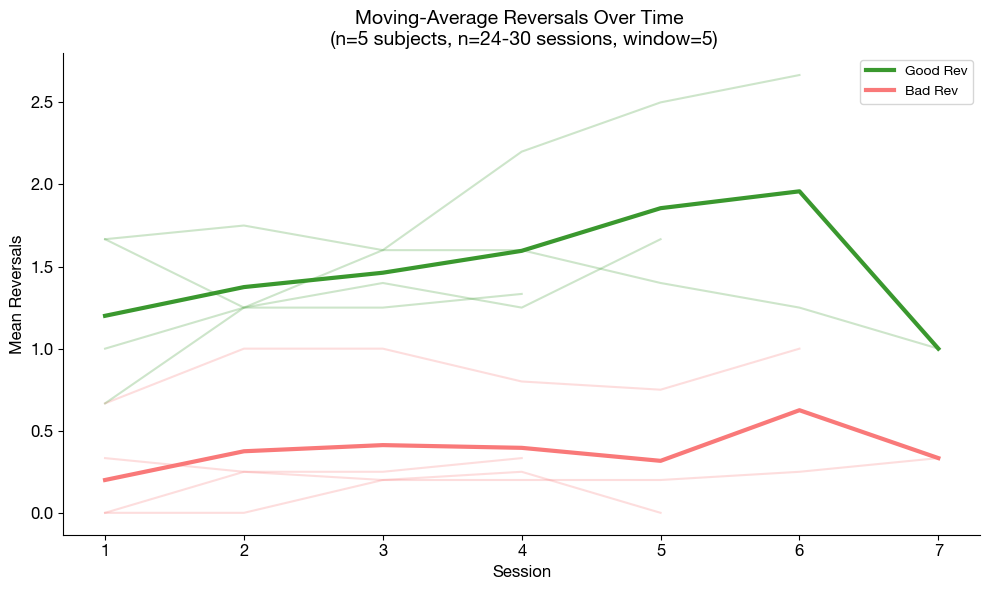

{'mean_good': array([1.2       , 1.375     , 1.4625    , 1.59583333, 1.85555556,
        1.95833333, 1.        ]),
 'mean_bad': array([0.2       , 0.375     , 0.4125    , 0.39583333, 0.31666667,
        0.625     , 0.33333333]),
 'good_mat': array([[1.66666667, 1.75      , 1.6       , 1.6       , 1.4       ,
         1.25      , 1.        ],
        [1.        , 1.25      , 1.6       , 2.2       , 2.5       ,
         2.66666667,        nan],
        [1.        ,        nan,        nan,        nan,        nan,
                nan,        nan],
        [0.66666667, 1.25      , 1.25      , 1.33333333,        nan,
                nan,        nan],
        [1.66666667, 1.25      , 1.4       , 1.25      , 1.66666667,
                nan,        nan]]),
 'bad_mat': array([[0.        , 0.        , 0.2       , 0.2       , 0.2       ,
         0.25      , 0.33333333],
        [0.66666667, 1.        , 1.        , 0.8       , 0.75      ,
         1.        ,        nan],
        [0.        ,     

In [7]:
plot_moving_avg_reversals_over_time(
    subjects_trials,
    window=5,
)


In [4]:
sessions_to_keep = ["ses-01_date-20260111", "ses-02_date-20260111",
                    "ses-03_date-20260112", "ses-04_date-20260112",
                    "ses-05_date-20260113", "ses-06_date-20260113",
                    "ses-07_date-20260114", "ses-08_date-20260114",
                    "ses-09_date-20260115", "ses-10_date-20260115",
                    "ses-11_date-20260116", "ses-12_date-20260116",
                    "ses-13_date-20260117", "ses-14_date-20260117",
                    "ses-15_date-20260118", "ses-16_date-20260118"]
# subjects_to_keep = ["MY_04_N", "MY_04_L", "MY_04_R", "MY_05_N", "MY_05_R"]
subjects_trials = filter_trials_by_session(subjects_trials, sessions_to_keep)
# subjects_trials = filter_trials_by_subject(subjects_trials, subjects_to_keep)

In [4]:
sessions_to_keep = ["ses-17_date-20260119", "ses-18_date-20260119",
                    "ses-19_date-20260120", "ses-20_date-20260120",
                    "ses-21_date-20260121", "ses-22_date-20260121",
                    "ses-23_date-20260122", "ses-24_date-20260122",
                    "ses-25_date-20260123", "ses-26_date-20260123",
                    "ses-27_date-20260124", "ses-28_date-20260124",
                    "ses-29_date-20260125", "ses-30_date-20260125"]
# subjects_to_keep = ["MY_04_N", "MY_04_L", "MY_04_R", "MY_05_N", "MY_05_R"]
subjects_trials = filter_trials_by_session(subjects_trials, sessions_to_keep)
# subjects_trials = filter_trials_by_subject(subjects_trials, subjects_to_keep)

In [ ]:
reversal_windows = get_good_reversal_info(subjects_trials, include_first_block=True)
rank_counts_by_good_reversal = get_rank_counts_by_good_reversal(reversal_windows)
p_values = pvalue_paired_t_best_vs_second_vs_third(rank_counts_by_good_reversal)
plot_rank_proportions(rank_counts_by_good_reversal, average_across_mice_pvalues=p_values)

In [ ]:
reversal_windows = get_good_reversal_info(subjects_trials)
early, late = split_good_reversals_early_late(reversal_windows, first_n=2)
first_leave_per_subject = get_first_leave_after_good_reversals(late)
mean, se, n_subjects = average_first_leave_across_subjects(first_leave_per_subject)
p_value = pvalue_paired_t_new_vs_third(first_leave_per_subject, alternative="greater")
plot_first_leave_after_good_reversals(mean, se, first_leave_per_subject, p_value, save_path=None)

In [ ]:
bad_reversals = get_bad_reversal_info(subjects_trials, include_first_block=True)

In [30]:
merged, _ = get_vars_across_all_sessions(subjects_trials)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111


In [32]:
merged['MY_04_L'].keys()

dict_keys(['trial', 'good_reversals', 'bad_reversals', 'blocks', 'trials_in_block', 'reward_magnitudes_by_tower', 'choices_by_tower', 'choices_by_rank'])

In [4]:
def make_arm_mapping(tower_keys):
    """Deterministic mapping: sorted tower keys -> Arm1/Arm2/Arm3."""
    keys_sorted = sorted(list(tower_keys))
    return {k: f"Arm{i+1}" for i, k in enumerate(keys_sorted)}

def remap_tower_dict_to_arms(d, mapping):
    """Remap {tower: list} -> {ArmX: list} using mapping[tower]."""
    out = {}
    for tower, arr in d.items():
        if tower in mapping:
            out[mapping[tower]] = arr
    return out

def get_chosen_reward_per_trial(choices_by_tower, reward_magnitudes_by_tower):
    """
    Returns:
        rewards: list length n_trials, where rewards[t] is the reward magnitude
                 of the chosen tower at trial t.

    Args:
        strict: if True, raises if a trial is not exactly one-hot.
                if False, returns fill_value for ambiguous/missing trials.
        fill_value: value to use when strict=False and choice is ambiguous/missing.
    """
    towers = list(reward_magnitudes_by_tower.keys())
    if not towers:
        return []

    # Use the minimum available length across towers to avoid IndexError
    n_trials = min(len(reward_magnitudes_by_tower[t]) for t in towers)

    # Ensure we have choice arrays for the same towers
    missing = [t for t in towers if t not in choices_by_tower]
    if missing:
        raise KeyError(f"choices_by_tower missing towers: {missing}")

    # Also ensure choice arrays are long enough
    n_trials = min(n_trials, *(len(choices_by_tower[t]) for t in towers))

    rewards = []
    for i in range(n_trials):
        chosen = [t for t in towers if choices_by_tower[t][i] == 1]

        if len(chosen) != 1:
            raise ValueError(f"Trial {i}: expected exactly one chosen tower, got {chosen}")

        t = chosen[0]
        rewards.append(reward_magnitudes_by_tower[t][i])

    return rewards

In [11]:
import numpy as np

def format_glm_input(data, input_dimension=29, drop_redundant_cols=True):
    merged_data_across_subjects, _ = get_vars_across_all_sessions(data)
    regressors_across_subjects = {}
    true_choices_across_subjects = {}

    # columns that are redundant given one-hot choice structure
    drop_cols = [3, 6, 9, 12, 19, 22, 25, 28]  # Arm3 for choices + Arm3 for interactions
    keep_cols = [i for i in range(input_dimension) if i not in drop_cols]

    for subject in merged_data_across_subjects.keys():
        current_subject_data = merged_data_across_subjects[subject]

        choices_by_tower = current_subject_data["choices_by_tower"]
        chosen_rewards = get_chosen_reward_per_trial(
            choices_by_tower,
            current_subject_data["reward_magnitudes_by_tower"]
        )

        tower_to_arm = make_arm_mapping(choices_by_tower.keys())
        choices_by_arm = remap_tower_dict_to_arms(choices_by_tower, tower_to_arm)

        num_trials = len(current_subject_data["trial"])
        regressors = np.zeros((num_trials, input_dimension))
        true_choices = np.zeros((num_trials, len(choices_by_tower.keys())))

        for t in range(1, num_trials):
            # explicit ordering = Arm1, Arm2, Arm3
            true_choices[t, :] = [
                choices_by_arm["Arm1"][t],
                choices_by_arm["Arm2"][t],
                choices_by_arm["Arm3"][t],
            ]

            regressors[t, 0] = 1  # Bias term

            # lag 1
            regressors[t, 1] = choices_by_arm["Arm1"][t - 1]
            regressors[t, 2] = choices_by_arm["Arm2"][t - 1]
            regressors[t, 3] = choices_by_arm["Arm3"][t - 1]
            regressors[t, 13] = chosen_rewards[t - 1]
            regressors[t, 17] = choices_by_arm["Arm1"][t - 1] * chosen_rewards[t - 1]
            regressors[t, 18] = choices_by_arm["Arm2"][t - 1] * chosen_rewards[t - 1]
            regressors[t, 19] = choices_by_arm["Arm3"][t - 1] * chosen_rewards[t - 1]

            # lag 2
            if t >= 2:
                regressors[t, 4] = choices_by_arm["Arm1"][t - 2]
                regressors[t, 5] = choices_by_arm["Arm2"][t - 2]
                regressors[t, 6] = choices_by_arm["Arm3"][t - 2]
                regressors[t, 14] = chosen_rewards[t - 2]
                regressors[t, 20] = choices_by_arm["Arm1"][t - 2] * chosen_rewards[t - 2]
                regressors[t, 21] = choices_by_arm["Arm2"][t - 2] * chosen_rewards[t - 2]
                regressors[t, 22] = choices_by_arm["Arm3"][t - 2] * chosen_rewards[t - 2]

            # lag 3
            if t >= 3:
                regressors[t, 7] = choices_by_arm["Arm1"][t - 3]
                regressors[t, 8] = choices_by_arm["Arm2"][t - 3]
                regressors[t, 9] = choices_by_arm["Arm3"][t - 3]
                regressors[t, 15] = chosen_rewards[t - 3]
                regressors[t, 23] = choices_by_arm["Arm1"][t - 3] * chosen_rewards[t - 3]
                regressors[t, 24] = choices_by_arm["Arm2"][t - 3] * chosen_rewards[t - 3]
                regressors[t, 25] = choices_by_arm["Arm3"][t - 3] * chosen_rewards[t - 3]

            # lag 4
            if t >= 4:
                regressors[t, 10] = choices_by_arm["Arm1"][t - 4]
                regressors[t, 11] = choices_by_arm["Arm2"][t - 4]
                regressors[t, 12] = choices_by_arm["Arm3"][t - 4]
                regressors[t, 16] = chosen_rewards[t - 4]
                regressors[t, 26] = choices_by_arm["Arm1"][t - 4] * chosen_rewards[t - 4]
                regressors[t, 27] = choices_by_arm["Arm2"][t - 4] * chosen_rewards[t - 4]
                regressors[t, 28] = choices_by_arm["Arm3"][t - 4] * chosen_rewards[t - 4]

        # drop first trial (no history)
        regressors = regressors[1:, :]
        true_choices = true_choices[1:, :]

        # drop redundant columns to make X full rank
        if drop_redundant_cols:
            regressors = regressors[:, keep_cols]

        regressors_across_subjects[subject] = regressors
        true_choices_across_subjects[subject] = true_choices

    return regressors_across_subjects, true_choices_across_subjects, keep_cols

In [9]:
def format_glm_input(data, input_dimension=29):
    merged_data_across_subjects, _ = get_vars_across_all_sessions(data)
    regressors_across_subjects = {}
    true_choices_across_subjects = {}
    for subject in merged_data_across_subjects.keys():
        current_subject_data = merged_data_across_subjects[subject]

        choices_by_tower = current_subject_data["choices_by_tower"]
        chosen_rewards = get_chosen_reward_per_trial(choices_by_tower, current_subject_data["reward_magnitudes_by_tower"])

        tower_to_arm = make_arm_mapping(choices_by_tower.keys())
        choices_by_arm = remap_tower_dict_to_arms(choices_by_tower, tower_to_arm)

        num_trials = len(current_subject_data['trial'])
        regressors = np.zeros((num_trials, input_dimension))
        true_choices = np.zeros((num_trials, len(choices_by_tower.keys())))

        # Fill input features
        # 0: bias
        # 1: prev choice arm 1
        # 2: prev choice arm 2
        # 3: prev choice arm 3
        # 4: n - 1 choice arm 1
        # 5: n - 1 choice arm 2
        # 6: n - 1 choice arm 3
        # 7: n - 2 choice arm 1
        # 8: n - 2 choice arm 2
        # 9: n - 2 choice arm 3
        # 10: n - 3 choice arm 1
        # 11: n - 3 choice arm 2
        # 12: n - 3 choice arm 3
        # 13: prev reward
        # 14: n - 1 reward
        # 15: n - 2 reward
        # 16: n - 3 reward
        # 17: prev choice arm 1 x reward
        # 18: prev choice arm 2 x reward
        # 19: prev choice arm 3 x reward
        # 20: n - 1 choice arm 1 x reward
        # 21: n - 1 choice arm 2 x reward
        # 22: n - 1 choice arm 3 x reward
        # 23: n - 2 choice arm 1 x reward
        # 24: n - 2 choice arm 2 x reward
        # 25: n - 2 choice arm 3 x reward
        # 26: n - 3 choice arm 1 x reward
        # 27: n - 3 choice arm 2 x reward
        # 28: n - 3 choice arm 3 x reward
        for t in range(1, num_trials):
            true_choices[t, :] = [choices_by_arm[arm][t] for arm in sorted(choices_by_arm.keys())]

            regressors[t, 0] = 1  # Bias term
            regressors[t, 1] = choices_by_arm['Arm1'][t-1]
            regressors[t, 2] = choices_by_arm['Arm2'][t-1]
            regressors[t, 3] = choices_by_arm['Arm3'][t-1]
            regressors[t, 13] = chosen_rewards[t-1]
            regressors[t, 17] = choices_by_arm['Arm1'][t-1] * chosen_rewards[t-1]
            regressors[t, 18] = choices_by_arm['Arm2'][t-1] * chosen_rewards[t-1]
            regressors[t, 19] = choices_by_arm['Arm3'][t-1] * chosen_rewards[t-1]

            if t >= 2:
                regressors[t, 4] = choices_by_arm['Arm1'][t-2]
                regressors[t, 5] = choices_by_arm['Arm2'][t-2]
                regressors[t, 6] = choices_by_arm['Arm3'][t-2]
                regressors[t, 14] = chosen_rewards[t-2]
                regressors[t, 20] = choices_by_arm['Arm1'][t-2] * chosen_rewards[t-2]
                regressors[t, 21] = choices_by_arm['Arm2'][t-2] * chosen_rewards[t-2]
                regressors[t, 22] = choices_by_arm['Arm3'][t-2] * chosen_rewards[t-2]
            if t >= 3:
                regressors[t, 7] = choices_by_arm['Arm1'][t-3]
                regressors[t, 8] = choices_by_arm['Arm2'][t-3]
                regressors[t, 9] = choices_by_arm['Arm3'][t-3]
                regressors[t, 15] = chosen_rewards[t-3]
                regressors[t, 23] = choices_by_arm['Arm1'][t-3] * chosen_rewards[t-3]
                regressors[t, 24] = choices_by_arm['Arm2'][t-3] * chosen_rewards[t-3]
                regressors[t, 25] = choices_by_arm['Arm3'][t-3] * chosen_rewards[t-3]
            if t >= 4:
                regressors[t, 10] = choices_by_arm['Arm1'][t-4]
                regressors[t, 11] = choices_by_arm['Arm2'][t-4]
                regressors[t, 12] = choices_by_arm['Arm3'][t-4]
                regressors[t, 16] = chosen_rewards[t-4]
                regressors[t, 26] = choices_by_arm['Arm1'][t-4] * chosen_rewards[t-4]
                regressors[t, 27] = choices_by_arm['Arm2'][t-4] * chosen_rewards[t-4]
                regressors[t, 28] = choices_by_arm['Arm3'][t-4] * chosen_rewards[t-4]
        regressors = regressors[1:, :]
        true_choices = true_choices[1:, :]
        regressors_across_subjects[subject] = regressors
        true_choices_across_subjects[subject] = true_choices
    return regressors_across_subjects, true_choices_across_subjects

In [12]:
regressors_across_subjects, true_choices_across_subjects, keep_cols = format_glm_input(subjects_data)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111


In [21]:
for subject in regressors_across_subjects.keys():
    X = regressors_across_subjects[subject]
    y = true_choices_across_subjects[subject]

    model = sm.MNLogit(y, X)
    result = model.fit(method="newton", maxiter=100, disp=False)

    print(f"Subject: {subject}")
    print(result.summary())
    print("\n")

Subject: MY_04_N
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  912
Model:                        MNLogit   Df Residuals:                      870
Method:                           MLE   Df Model:                           40
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                 0.09688
Time:                        16:54:19   Log-Likelihood:                -904.15
converged:                       True   LL-Null:                       -1001.1
Covariance Type:            nonrobust   LLR p-value:                 4.305e-22
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1367      0.357      0.383      0.702      -0.562       0.836
x1             0.4022      0.365      1.103      0.270      -0.312       1.117
x2             0.8202      0.371   

In [15]:
regressor_names = [
    "choice1", "choice2", "reward", "reward x choice1", "reward x choice2",
    "n-1 choice1", "n-1 choice2", "n-1 reward", "n-1 reward x choice1", "n-1 reward x choice2",
    "n-2 choice1", "n-2 choice2", "n-2 reward", "n-2 reward x choice1", "n-2 reward x choice2",
    "n-3 choice1", "n-3 choice2", "n-3 reward", "n-3 reward x choice1", "n-3 reward x choice2"
]

for subject in regressors_across_subjects:
    X = np.asarray(regressors_across_subjects[subject][:, 1:])
    y = np.asarray(true_choices_across_subjects[subject][:, 1:])

    assert X.shape[1] == len(regressor_names), (X.shape[1], len(regressor_names))

    X_df = pd.DataFrame(X, columns=regressor_names)
    X_df = sm.add_constant(X_df, has_constant="add")

    model = sm.MNLogit(y, X_df)
    res = model.fit(method="newton", maxiter=100, disp=False)

    print(subject)
    print(res.summary())


MY_04_R
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1094
Model:                        MNLogit   Df Residuals:                     1073
Method:                           MLE   Df Model:                           20
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                  0.3042
Time:                        17:04:09   Log-Likelihood:                -450.50
converged:                       True   LL-Null:                       -647.44
Covariance Type:            nonrobust   LLR p-value:                 3.783e-71
                 y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7764      0.361     -2.153      0.031      -1.483      -0.070
choice1                  0.2763      0.322      0.857      0.391      -0.355       0.908
choi

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

regressor_names = [
    "choice1", "choice2", "reward", "reward_x_choice1", "reward_x_choice2",
    "n1_choice1", "n1_choice2", "n1_reward", "n1_reward_x_choice1", "n1_reward_x_choice2",
    "n2_choice1", "n2_choice2", "n2_reward", "n2_reward_x_choice1", "n2_reward_x_choice2",
    "n3_choice1", "n3_choice2", "n3_reward", "n3_reward_x_choice1", "n3_reward_x_choice2"
]

X_all = []
y_all = []

for subject in regressors_across_subjects:
    X = np.asarray(regressors_across_subjects[subject])

    # If your first column is bias/intercept, drop it (since we'll add const once)
    X = X[:, 1:]

    # y handling: choose ONE of these depending on your format:
    y_raw = np.asarray(true_choices_across_subjects[subject])
    if y_raw.ndim == 2:
        y = y_raw.argmax(axis=1).astype(int)   # one-hot -> labels
    else:
        y = y_raw.astype(int)

    assert X.shape[1] == len(regressor_names), (subject, X.shape, len(regressor_names))
    assert len(y) == X.shape[0], (subject, len(y), X.shape[0])

    X_df = pd.DataFrame(X, columns=regressor_names)
    X_df["subject"] = subject

    X_all.append(X_df)
    y_all.append(y)

X_all = pd.concat(X_all, ignore_index=True)
y_all = np.concatenate(y_all)

# Subject fixed effects (baseline differences)
X_all = pd.get_dummies(X_all, columns=["subject"], drop_first=True)

# Add intercept once
X_all = sm.add_constant(X_all, has_constant="add")

model = sm.MNLogit(y_all, X_all)
res = model.fit(method="newton", maxiter=200, disp=True)

print(res.summary())


In [14]:
X_by, Y_by, keep_cols = format_glm_input(subjects_trials)

X = X_by["MY_04_L"]
Y = Y_by["MY_04_L"]
y = np.argmax(Y, axis=1)

print("rank vs p:", np.linalg.matrix_rank(X), X.shape[1])  # should match

mn = sm.MNLogit(y, X)
res = mn.fit(method="bfgs", maxiter=500, disp=False)
print(res.summary())

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
rank vs p: 21 21
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1052
Model:                        MNLogit   Df Residuals:                     1010
Method:                           MLE   Df Model:                           40
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                 0.07093
Time:                        15:57:57   Log-Likelihood:                -1067.2
converged:                       True   LL-Null:                       -1148.6
Covariance Type:            nonrobust   LLR p-value:                 8.996e-17
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5848      0.318      1.839      0.066      -0.038       1.208
x1            -0.5852      0

In [13]:
data = {
    "MY_04_L": [24, 12, 7],
    "MY_04_N": [24, 13, 6, 8],
    "MY_04_R": [28, 15],
    "MY_05_L": [24, 18, 8],
    "MY_05_N": [30, 11, 8],
    "MY_05_R": [29, 18],
}

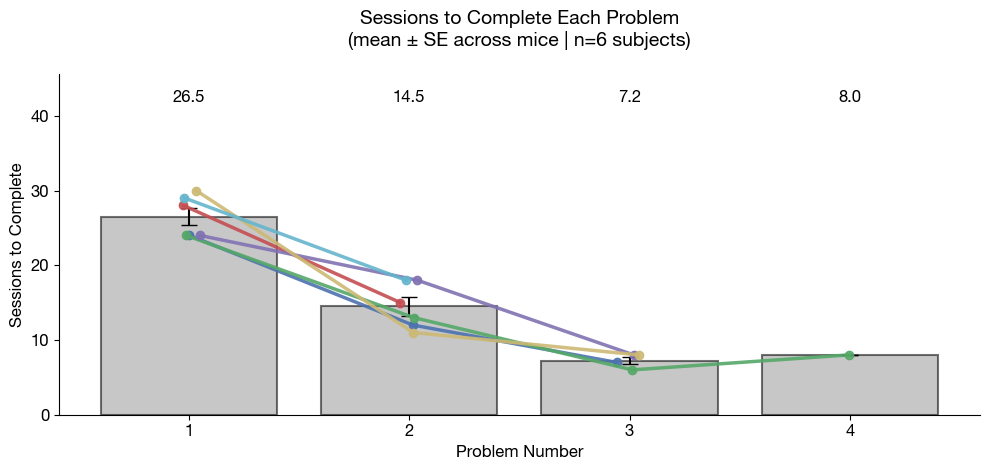

In [14]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica Neue", "Helvetica", "Arial"]
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

MOUSE_COLORS = [
    "#4C72B0","#55A868","#C44E52","#8172B2",
    "#CCB974","#64B5CD","#8C8C8C","#DD8452",
    "#937860","#DA8BC3","#8C6D31","#1F77B4",
]

def compute_problem_length_summary(data):
    """
    data: dict[str, list[int|float]]
      mouse -> [sessions_to_complete_problem1, problem2, ...]
      mice can have different number of problems.

    Returns a dict compatible with the plotting function below.
    """
    mice = list(data.keys())
    max_problems = max((len(v) for v in data.values()), default=0)
    blocks = list(range(1, max_problems + 1))  # problem numbers (1-indexed)

    # Per-mouse mapping: problem_number -> sessions
    per_mouse_blocklens = {}
    for m, vals in data.items():
        per_mouse_blocklens[m] = {i + 1: float(v) for i, v in enumerate(vals)}

    means, ses, ns = [], [], []
    for b in blocks:
        vals_b = []
        for m in mice:
            if b in per_mouse_blocklens[m]:
                vals_b.append(per_mouse_blocklens[m][b])

        vals_b = np.asarray(vals_b, dtype=float)
        n = int(vals_b.size)
        ns.append(n)

        if n == 0:
            means.append(np.nan)
            ses.append(np.nan)
        elif n == 1:
            means.append(float(vals_b.mean()))
            ses.append(0.0)
        else:
            means.append(float(vals_b.mean()))
            ses.append(float(vals_b.std(ddof=1) / np.sqrt(n)))

    return {
        "blocks": blocks,
        "means": means,
        "ses": ses,
        "ns": ns,  # n contributing mice per problem
        "per_mouse_blocklens": per_mouse_blocklens,
        "mice": mice,
    }

def plot_problem_lengths(problem_summary, jitter=0.06, annotate_y=None, save_path=None):
    """
    Plots mean ± SE across mice per problem, plus per-mouse lines.
    """
    blocks = problem_summary["blocks"]
    means = np.asarray(problem_summary["means"], dtype=float)
    ses = np.asarray(problem_summary["ses"], dtype=float)
    ns = problem_summary["ns"]
    per_mouse_blocklens = problem_summary["per_mouse_blocklens"]
    mice = problem_summary["mice"]

    mouse_to_color = {m: MOUSE_COLORS[i % len(MOUSE_COLORS)] for i, m in enumerate(mice)}

    fig, ax = plt.subplots(figsize=(10, 4.8))
    x = np.arange(len(blocks))

    ax.bar(
        x, means, yerr=ses, capsize=6,
        edgecolor="black", linewidth=1.5, alpha=0.55,
        color=["#999999"] * len(blocks), zorder=1
    )

    # annotation y default
    finite_top = np.nanmax(means + ses) if np.any(np.isfinite(means + ses)) else 1.0
    if annotate_y is None:
        annotate_y = max(float(finite_top), 1.0) * 1.5

    for xi, m, n in zip(x, means, ns):
        if np.isfinite(m):
            ax.text(
                xi, annotate_y, f"{m:.1f}",
                ha="center", va="bottom", fontsize=12, clip_on=False
            )

    legend_handles = []
    for m in mice:
        bl = per_mouse_blocklens[m]
        c = mouse_to_color[m]

        xs, ys = [], []
        for bi, b in enumerate(blocks):
            if b in bl:
                xs.append(bi)
                ys.append(bl[b])

        if not xs:
            continue

        xs = np.asarray(xs, float)
        ys = np.asarray(ys, float)

        if jitter > 0:
            xs = xs + np.random.uniform(-jitter, jitter, size=len(xs))

        ax.plot(
            xs, ys, color=c, linewidth=2.5, alpha=0.9,
            marker="o", markersize=6, zorder=3
        )
        legend_handles.append(
            Line2D([0],[0], color=c, lw=2.5, marker="o", label=f"{m} (n={len(ys)} problems)")
        )

    #ax.legend(handles=legend_handles, fontsize=10, loc="lower right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks(x)
    ax.set_xticklabels([str(b) for b in blocks], fontsize=12)
    ax.set_xlabel("Problem Number", fontsize=12)
    ax.set_ylabel("Sessions to Complete", fontsize=12)

    ax.set_title(
        "Sessions to Complete Each Problem\n"
        f"(mean ± SE across mice | n={len(mice)} subjects)",
        pad=20
    )

    top_needed = max(annotate_y, float(finite_top))
    ax.set_ylim(0, top_needed * 1.10)

    plt.tight_layout()

    if save_path:
        base = Path(save_path)
        base.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(base) + ".pdf", bbox_inches="tight")
        fig.savefig(str(base) + ".png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)

summary = compute_problem_length_summary(data)
plot_problem_lengths(summary, jitter=0.06, save_path=None)  # or save_path="outputs/problem_lengths"
